In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

SEMILLA_ALEATORIEDAD = 123
np.random.seed(SEMILLA_ALEATORIEDAD)

In [2]:
from pandas import set_option
#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Crea un gráfico circular con el porcentaje de fotógrafos prefesionales y los que no
def show_loan_distrib(y):
    i=0
    normales = 0
    fotografos = 0
    while (i<len(y)):
        if y[i]==0:
            normales+=1
        else: fotografos+=1
        i+=1

    tamanos = [fotografos, normales]
    etiquetas = [f'Fotógrafos profesionales - {tamanos[0]}', f'Otros usuarios - {tamanos[1]}']

    plt.pie(tamanos, labels=etiquetas, autopct = '%1.1f%%', explode = [0, 0.1])
    plt.show()

In [4]:
# Función para representar la matriz de confusión de las etiquetas

from sklearn.metrics import confusion_matrix

def matrix_confusion_etiq(etiq_manual, etiq_auto):
    cm = confusion_matrix(etiq_manual, etiq_auto) 
    print(cm)
    
    # Para mostrar la información en porcetanjes también
    cm_porcentaje = cm.astype('float')/cm.sum()*100

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm):
        percentage = cm_porcentaje[i, j]
        if i==0 and j==0:
            ax.text(j, i, f'{val} ({percentage:.2f}%)', ha='center', va='center', color = 'white')
        else:
            ax.text(j, i, f'{val} ({percentage:.2f}%)', ha='center', va='center', color = 'black')


    labels = ['No Fotógrafo', 'Fotógrafo']

    ax.set_xlabel('Etiqueta Automática')
    ax.set_ylabel('Etiqueta Manual')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de Confusión de etiquetados')

    plt.show() 

In [5]:
# Función para representar la matriz de confusión de las predicciones

from sklearn.metrics import confusion_matrix

def matrix_confusion_pred(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred) 
    print(cm)
    
    # Para mostrar la información en porcetanjes también
    #cm_porcentaje = cm.astype('float')/cm.sum()*100

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm):
        #percentage = cm_porcentaje[i, j]
        fontsize = 12
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, f'{val}', ha='center', va='center', color=color, fontsize=fontsize)

    labels = ['No Fotógrafo', 'Fotógrafo']

    ax.set_xlabel('Predicción')
    ax.set_ylabel('Ground-truth')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión de la predicción de expertos')

    plt.show() 

In [6]:
# Función que plotea la curva ROC

from sklearn.metrics import roc_curve, auc

def roc_auc(y_test, y_pred_test_proba):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test_proba)
    roc_auc = auc(fpr, tpr)

    #plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [7]:
# Función que plotea la curva Precision-Recall

from sklearn.metrics import precision_recall_curve, auc
from numpy import argmax

def pr_auc(y_test, y_pred_test_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test_proba)
    
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    
    pr_auc = auc(recall, precision)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label= f'PR curve (area = {pr_auc:.2f})')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    return thresholds[ix]

In [8]:
# Función que representa en un diagrama de barras las medidas de desempeño en la predicción

# valores es el array con los valores de las métricas que queremos plotear
# ponemos el título del plot como argumento para especificar el caso que estamos ploteando
def show_bars_metrics(valores, titulo):
    nombres = ["Accuracy","Precision","Recall","f1", "ROC-AUC", "AP/PR-AUC"]
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Nombres y valores de las medidas
    #valores = fila_max_manual.values[2:7]

    # Crear una figura y un eje
    fig, ax = plt.subplots()

    # Crear la gráfica de barras
    bars = ax.bar(nombres, valores, color=color, width=0.65)

    # Agregar etiquetas de valores a las barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=16)

    # Agregar título y etiquetas de ejes
    ax.set_title(titulo, fontweight='bold', fontsize=20)
    ax.set_xlabel('Medidas', fontsize=12)
    ax.set_ylabel('Valores', fontsize=12)
    plt.yticks(fontsize=14)

    # Mostrar la gráfica
    plt.show()

In [9]:
# Función que dibuja las distribuciones de las características individuales, para cada tipo de etiquetado

# str_etiq es el string del nombre que tiene la variable de clase en el data set df
def show_individual_distrib(df, str_etiq):
    df_prof = df[df[str_etiq] == 1]
    df_noProf = df[df[str_etiq] == 0]

    # Quitamos la columna de respuesta
    df_dist = df_manual.iloc[:,:-1]

    # Calculamos el número de filas y columnas necesarias para organizar los subtrazados
    n_rows = (len(df_dist.columns) + 3) // 4  # Aproximadamente 4 subplots por fila
    n_cols = min(len(df_dist.columns), 4)

    # Ajustamos el tamaño de la figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))

    # Ploteamos la distribución de cada columna en un subplot separado
    for i, column in enumerate(df_dist.columns):
        ax = axes[i // n_cols, i % n_cols]  # Calculamos la posición del subplot en la cuadrícula
        # Cada diagrama tendrá 40 barras como máximo
        df_prof[column].hist(bins=40, color = 'orange', alpha = 0.5, ax=ax)
        df_noProf[column].hist(bins=40, color = 'blue', alpha = 0.5,ax=ax)
        ax.set_title('{}'.format(column))
        ax.set_xlabel('Valor')
        ax.set_ylabel('Frecuencia')

    # Ajusta automáticamente el diseño de la figura para evitar superposiciones
    plt.tight_layout()
    plt.show()

In [10]:
# Nos devuelve la información sobre la asimetría y la curtosis

# Nos devuelve el skewness y la kurtosis de cada característica
from scipy.stats import skew, kurtosis

def info_asymetry(df):
    skewness = df.apply(skew)
    kurt = df.apply(kurtosis)

    result = pd.DataFrame({
        'Feature': df.columns,
        'Skewness': skewness,
        'Kurtosis': kurt
    }).reset_index(drop=True)
    return result

In [11]:
# Dibuja la matriz de correlación de Pearson entre los atributos

def show_correlation(df):
    correlation_matrix=df.corr().abs()
    sns.set(font_scale = 0.8)

    f, ax = plt.subplots(figsize=(12,12))

    sns.heatmap(correlation_matrix, cmap='YlGnBu', square=True, ax = ax)

    # Rotar las etiquetas del eje x
    plt.xticks(rotation=90)

    f.tight_layout()

In [12]:
# Partición de los datos

def data_partition(df, proportion, str_etiq):
    train_df, test_df = train_test_split(df, test_size=proportion, random_state=SEMILLA_ALEATORIEDAD, stratify=df[str_etiq])

    # Separamos la variable de clase de las demás
    train_manual_x = train_df.loc[:, train_df.columns != str_etiq]
    train_manual_y = train_df.loc[:, str_etiq]

    test_manual_x = test_df.loc[:, test_df.columns != str_etiq]
    test_manual_y = test_df.loc[:, str_etiq]
    
    return [train_manual_x, train_manual_y, test_manual_x, test_manual_y]

In [13]:
# Escalado con StandardScaler

from sklearn.preprocessing import StandardScaler

# Escalado estándar
def std_Scaler_data(train_x, test_x):
    
    scaler = StandardScaler()
    scaler.fit(train_x)
    trainScaled_x = pd.DataFrame(scaler.transform(train_x), columns=train_x.columns, index=train_x.index)
    testScaled_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns, index=test_x.index)
    return [trainScaled_x, testScaled_x]

In [14]:
# Escalado con QuantileTransformer

from sklearn.preprocessing import QuantileTransformer

# QuantileTransformer
def qt_Transformer_data(train_x, test_x):
    
    qt = QuantileTransformer(output_distribution='normal')
    qt.fit(train_x)
    trainQT_x = pd.DataFrame(qt.transform(train_x), columns=train_x.columns, index=train_x.index)
    testQT_x = pd.DataFrame(qt.transform(test_x), columns=test_x.columns, index=test_x.index)
    return [trainQT_x, testQT_x]

In [15]:
# Clase que representa el transformador donde se elimina del conjunto las columnas con valores constantes

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ConstantValueThresholdEliminator(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        # Calcular el umbral de valores constantes para cada columna
        for column in X.columns:
            most_frequent_value_count = X[column].value_counts().max()
            if most_frequent_value_count / len(X) > self.threshold:
                self.columns_to_drop.append(column)
        return self

    def transform(self, X, y=None):
        # Eliminar las columnas que exceden el umbral de valores constantes
        return X.drop(columns=self.columns_to_drop)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [16]:
# Función que hace uso de la clase ConstantValueThresholdEliminator para eliminar columnas constantes

def constant_elimination(train_x, test_x, threshold):
    transformer_cte = ConstantValueThresholdEliminator(threshold=threshold)
    transformer_cte.fit(train_x)
    train_cte_x = transformer_cte.transform(train_x)
    test_cte_x = transformer_cte.transform(test_x)
    return [train_cte_x, test_cte_x]

In [17]:
# Clase que representa el transformador donde se elimina del conjunto las columnas más correlacionadas

from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_keep_ = None
        self.to_remove = None

    def fit(self, X, y=None):
        # Convertimos a DataFrame si no lo es
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calculamos la matriz de correlación
        corr_matrix = X.corr().abs()

        # Calculamos la correlación media de cada variable con el resto
        mean_correlation = corr_matrix.mean(axis=0)

        # Identificamos las variables a eliminar basadas en el umbral
        self.to_remove = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    if mean_correlation.iloc[i] > mean_correlation.iloc[j]:
                        self.to_remove.add(corr_matrix.columns[i])
                    else:
                        self.to_remove.add(corr_matrix.columns[j])

        # Guardamos las variables a mantener
        self.features_to_keep_ = [col for col in X.columns if col not in self.to_remove]
        return self
    def get_removed(self):
        return self.to_remove

    def transform(self, X, y=None):
        # Convertimos a DataFrame si no lo es
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Retornamos el dataset con las variables seleccionadas
        return X[self.features_to_keep_]

    def get_support(self):
        # Método para obtener las características seleccionadas
        return self.features_to_keep_

In [18]:
# Función que usa CorrelationThresholdTransformer para eliminar columnas correlacionadas

def corr_elimination(train_x, test_x, threshold):
    transformer_corr = CorrelationThresholdTransformer(threshold=threshold)
    transformer_corr.fit(train_x)
    train_corr_x = transformer_corr.transform(train_x)
    test_corr_x = transformer_corr.transform(test_x)
    #print(transformer_corr.get_removed())
    return [train_corr_x, test_corr_x]

In [19]:
# Función que usa un entrenamiento de Random Forest para seleccionar atributos poco relevantes en el entrenamiento

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

def RelevantInformationEliminator(X, y, threshold=0.01):
    clf = RandomForestClassifier(n_estimators=250,
                              random_state=SEMILLA_ALEATORIEDAD)

    clf.fit(X, y)

    # Plot feature importance
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    #feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    features_eliminated = []
    for index in sorted_idx:
        if feature_importance[index] < threshold:
            features_eliminated.append(X.columns[index])

    return features_eliminated

In [20]:
# Función que elimina los atributos poco relevantes usando la función RelevantInformationEliminator

def low_relevance_elimination(train_x, train_y, test_x, threshold):
    # Seleccionamos las columnas poco relevantes
    features_eliminated = RelevantInformationEliminator(train_x, train_y, threshold)
    print(features_eliminated)
    train_rel_x = train_x.drop(columns = features_eliminated)
    test_rel_x = test_x.drop(columns = features_eliminated)
    return [train_rel_x, test_rel_x]

In [21]:
# Función que aplica PCA al conjunto de datos

from sklearn.decomposition import PCA

def dataset_pca(train_x, test_x, var_explicated):
    pca = PCA(n_components = var_explicated)
    train_pca_x = pca.fit_transform(train_x)
    test_pca_x = pca.transform(test_x)

    train_pca_x = pd.DataFrame(train_pca_x)
    test_pca_x = pd.DataFrame(test_pca_x)
    
    return [train_pca_x, test_pca_x]

In [22]:
# Función que aplica SMOTE al conjunto de datos

from imblearn.over_sampling import SMOTE

def dataset_smote(train_x, train_y, with_sampling_strategy, k_neighbors):
    if with_sampling_strategy and k_neighbors != 0:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD, sampling_strategy=0.5, k_neighbors=k_neighbors)
    elif with_sampling_strategy:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD, sampling_strategy=0.5)
    else:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD)
        
    smote_x, smote_y = oversample.fit_resample(train_x, train_y)
    return [smote_x, smote_y]

In [23]:
# Función que aplica el bloque de preprocesamiento al conjunto de datos

def dataset_bloque(train_x, train_y, test_x, threshold_cte, threshold_corr,
                  threshold_relevance):
    train_cte_x, test_cte_x = constant_elimination(train_x, test_x, threshold_cte)
    
    train_corr_cte_x, test_corr_cte_x = corr_elimination(train_cte_x, test_cte_x, threshold_corr)
    
    train_bloque_x, test_bloque_x = low_relevance_elimination(train_corr_cte_x, train_y, test_corr_cte_x, threshold_relevance)
    
    return [train_bloque_x, test_bloque_x]

In [24]:
# Función que crea la lista de conjuntos de datos con preprocesamientos distintos

def conjuntos_preprocesamiento(train_x, test_x, train_y, test_y,
                              with_smote=False, sampling_strategy = False, k_neighbors = 0):
    conjuntos = []
    
    trainScaled_x, testScaled_x = std_Scaler_data(train_x, test_x)
    conjuntos.append(["std", trainScaled_x, train_y, testScaled_x, test_y])
    
    
    trainQT_x, testQT_x = qt_Transformer_data(train_x, test_x)
    conjuntos.append(["qt", trainQT_x, train_y, testQT_x, test_y])
    
    if with_smote:
        smote_std_x, smote_std_y = dataset_smote(trainScaled_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["std_smote", smote_std_x, smote_std_y, testScaled_x, test_y])
        
        smote_qt_x, smote_qt_y = dataset_smote(trainQT_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["qt_smote", smote_qt_x, smote_qt_y, testQT_x, test_y])
        
    
    return conjuntos

In [25]:
# Función que establece los algoritmos de aprendizaje supervisado a usar

# Spot-Check Algorithms
def ImbGetBasedModelDef():
    basedModels = []
    # Lineales (estoy pensando en usar LR en lugar de esta)
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    # No lineales
    basedModels.append(('SVM'  , SVC(probability=True, class_weight='balanced')))
    # Ensamblados
    basedModels.append(('RF'   , RandomForestClassifier(class_weight='balanced')))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    
    return basedModels

In [26]:
# Función que aplica el bucle general de selección de modelos a partir de una búsqueda de hiperparámetros, para cada combinación
# de algoritmo y preprocesado

from sklearn import metrics

# El scoring por defecto es roc-auc, pero en clases desbalanceadas deberemos poner "average_precision"
def bucle_proceso_general(conjuntos,  grids, scoring = "roc_auc"):
    resultados = pd.DataFrame(columns = ["modelo", "conjunto", "accuracy", "precision", "recall", "f1", "AUC-ROC","AP/PR-AUC"])
    
    # Todo lo que nos aporta información sobre la predicción
    best_models = []
    best_hyperparams = []
    matrices_confusion = []
    y_pred_list = []
    y_pred_proba_list = []
    
    imbModels = ImbGetBasedModelDef()
    
    i = 0
    for model_name, model in imbModels:
        for cjto_name, x_train, y_train, x_test, y_test in conjuntos:

            grid_search = GridSearchCV(model, scoring=scoring, n_jobs= -1, verbose = 1, param_grid=grids[i], cv=5)
            grid_search.fit(x_train, y_train)
            
            best_model = grid_search.best_estimator_
            best_models.append([model_name+"-"+cjto_name, best_model])
            
            best_params = grid_search.best_params_
            best_hyperparams.append([model_name+"-"+cjto_name, best_params])

            y_pred = best_model.predict(x_test)
            y_pred_list.append([model_name+"-"+cjto_name, y_pred])
            
            y_pred_proba = best_model.predict_proba(x_test)[:,-1]
            y_pred_proba_list.append([model_name+"-"+cjto_name, y_pred_proba])

            print(model_name + " " + cjto_name)
            print()
            
            cm =metrics.confusion_matrix(y_test, y_pred)
            print(cm)
            
            matrices_confusion.append([model_name+"-"+cjto_name, cm])
            print(metrics.classification_report(y_test,y_pred))

            roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
            print("ROC-AUC", round(roc_auc, 4))
            
            average_precision = metrics.average_precision_score(y_test, y_pred_proba)
            print("AP/PR-AUC: ",round(average_precision,4))

            # Calcular las métricas de rendimiento
            accuracy = metrics.accuracy_score(y_test, y_pred)
            precision = metrics.precision_score(y_test, y_pred)
            recall = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)
            resultados.loc[len(resultados.index)] = [model_name, cjto_name, accuracy, precision, recall, f1, roc_auc, average_precision]

        i+=1
        
    return [resultados, best_models, best_hyperparams, matrices_confusion, y_pred_list, y_pred_proba_list]

In [27]:
# Función auxiliar que nos ayuda a encontrar el mejor modelo de la lista de modelos devuelta por el proceso de la función bucle_proceso_general

# nombre_buscado es el nombre de la mejor combinacion de preprocesado y algoritmo que buscamos en la
# lista de mejores modelos para cada combinación
def busca_tupla_nombre(nombre_buscado, best_models):
    tupla = None
    for nombre, params in best_hyperparams:
        if nombre == nombre_buscado:
            tupla = (nombre, params)
            break
    return tupla

In [28]:
# Función que devuelve el mejor resultado de la lista de resultados de la función bucle_proceso_general

# resultados es el dataframe con todos los resultados de cada combinación de preprocesado y algoritmo
# scoring es la columna que comparamos para sacar el mejor
def mejor_resultado(resultados, scoring):
    idx_max = resultados[scoring].idxmax()
    fila_max = resultados.loc[idx_max]
    print(fila_max)
    nombre_buscado = fila_max['modelo']+"-"+fila_max['conjunto']
    print(nombre_buscado)
    return [fila_max, nombre_buscado]

In [29]:
# Función que guarda de la lista de elementos obtenidos por la función bucle_proceso_general, aquel que nos haya dado los mejores resultados


def save_best(lista, file, nombre_buscado):
    tupla = None
    for nombre, elemento in lista:
        if nombre == nombre_buscado:
            tupla = (nombre, elemento)
            break

    joblib.dump(tupla, file)
    return tupla

In [30]:
def find_element(nombre, lista):
    for nombre_element, element in lista:
        if nombre_element == nombre:
            element_return = element
            break
    return element_return

In [31]:
def find_preproc(nombre, conjunto):
    for nombre_aux, train_x, train_y, test_x, test_y in conjunto:
        print(nombre_aux)
        if nombre == nombre_aux:
            tupla = [nombre_aux, train_x, train_y, test_x, test_y]
            break
    return tupla

In [32]:
# Función que devuelve las medidas de desempeño a partir de un modelo Dummy, que depende del parámetros strategy

from sklearn.dummy import DummyClassifier

def DummyResults(train_x, train_y, test_x, test_y, strategy="most_frequent"):
    # Crear el modelo dummy
    dummy_clf = DummyClassifier(strategy=strategy)

    dummy_clf.fit(train_x, train_y)

    # Hacer predicciones con el modelo dummy
    y_pred_dummy = dummy_clf.predict(test_x)
    y_pred_proba_dummy = dummy_clf.predict_proba(test_x)[:,-1]
    cm =metrics.confusion_matrix(test_y, y_pred_dummy)
    print(cm)

    print(metrics.classification_report(test_y,y_pred_dummy))
    
    # Calcular métricas de rendimiento
    f1 = metrics.f1_score(test_y, y_pred_dummy)
    accuracy = metrics.accuracy_score(test_y, y_pred_dummy)
    precision = metrics.precision_score(test_y, y_pred_dummy)
    recall = metrics.recall_score(test_y, y_pred_dummy)

    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    roc_auc = metrics.roc_auc_score(test_y, y_pred_proba_dummy)
    print("ROC-AUC", round(roc_auc, 4))
    
    average_precision = metrics.average_precision_score(test_y, y_pred_proba_dummy)
    print("AP/PR-AUC: ",round(average_precision,4))

Para obtener el dataset con los datos para la replicación de los experimentos, consultar el README del repositorio.

In [ ]:
DATASET_FLICKR =
DATASET_IG = 
DATASET_FLICKR_IG =

Grid de hiperparámetros a utilizar

In [33]:
grids = [
    {# LDA
        'solver' : ['svd', 'lsqr'],
        'n_components' : [None] + [1, 2, 5, 8, 13, 21, 34, 55],
        'store_covariance' : [True, False],
        'tol' : [1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
    },
    {# SVM
        'C': [1,10,100,1000],
        'gamma': [1,0.1,0.001,0.0001], 
        'kernel': ['linear','rbf']
    },
    {# RF
        'bootstrap': [True, False],
         'max_depth': [10, 50, 100, None],
         'max_features': ['auto', 'sqrt'],
        'criterion' :['gini', 'entropy'],
         'n_estimators': [200, 400, 600, 800]
    },
    {# GBM
        'n_estimators': [100, 200, 500],  # Número de árboles
        'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
        'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
        'max_features': ['auto', 'sqrt', 'log2']  # Fracción de características consideradas para dividir en cada nodo

    }
]

# Flickr

In [40]:
df_flickr = pd.read_csv(DATASET_FLICKR)
train_flickr_x, train_flickr_y, test_flickr_x, test_flickr_y = data_partition(df_flickr, 0.3, 'is_photographer')

In [41]:
conjuntos_flickr = conjuntos_preprocesamiento(train_flickr_x, test_flickr_x, train_flickr_y, test_flickr_y,
                              with_smote=True)
len(conjuntos_flickr)

C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(


4

In [75]:
import os

if (not os.path.exists(f"resultados_flickr.csv")):
    resultados_flickr, best_models_flickr, best_hyperparams_flickr, matrices_confusion_flickr, y_pred_list_flickr, y_pred_proba_list_flickr = bucle_proceso_general(conjuntos_flickr,  grids, scoring = "average_precision")
    resultados_flickr.to_csv("resultados_flickr.csv", index = False)
    
    fila_flickr, nombre_flickr = mejor_resultado(resultados_flickr, "AP/PR-AUC")
    
    best_model_flickr = save_best(best_models_flickr, 'mejor_modelo_flickr.joblib', nombre_flickr)
    best_params_flickr = save_best(best_hyperparams_flickr, 'mejor_params_flickr.joblib', nombre_flickr)
    best_matrix_flickr = save_best(matrices_confusion_flickr, 'mejor_matrix_flickr.joblib', nombre_flickr)
    best_ypred_flickr = save_best(y_pred_list_flickr, 'mejor_ypred_flickr.joblib', nombre_flickr)
    best_ypred_proba_flickr = save_best(y_pred_proba_list_flickr, 'mejor_ypred_proba_flickr.joblib', nombre_flickr)
else:
    resultados_flickr = pd.read_csv("resultados_flickr.csv")
    
    fila_flickr, nombre_flickr = mejor_resultado(resultados_flickr, "AP/PR-AUC")
    
    best_model_flickr = joblib.load('mejor_modelo_flickr.joblib')
    best_params_flickr = joblib.load('mejor_params_flickr.joblib')
    best_matrix_flickr = joblib.load('mejor_matrix_flickr.joblib')
    best_ypred_flickr = joblib.load('mejor_ypred_flickr.joblib')
    best_ypred_proba_flickr = joblib.load('mejor_ypred_proba_flickr.joblib')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
840 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 614, in fit
    raise Va

LDA std

[[43  3]
 [11  5]]
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86        46
         1.0       0.62      0.31      0.42        16

    accuracy                           0.77        62
   macro avg       0.71      0.62      0.64        62
weighted avg       0.75      0.77      0.75        62

ROC-AUC 0.8071
AP/PR-AUC:  0.5833
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
840 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 614, in fit
    raise Va

LDA qt

[[44  2]
 [10  6]]
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88        46
         1.0       0.75      0.38      0.50        16

    accuracy                           0.81        62
   macro avg       0.78      0.67      0.69        62
weighted avg       0.80      0.81      0.78        62

ROC-AUC 0.8274
AP/PR-AUC:  0.6442
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
840 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 614, in fit
    raise Va

LDA std_smote

[[39  7]
 [ 3 13]]
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89        46
         1.0       0.65      0.81      0.72        16

    accuracy                           0.84        62
   macro avg       0.79      0.83      0.80        62
weighted avg       0.86      0.84      0.84        62

ROC-AUC 0.8111
AP/PR-AUC:  0.5868
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
840 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
840 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 614, in fit
    raise Va

LDA qt_smote

[[36 10]
 [ 4 12]]
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84        46
         1.0       0.55      0.75      0.63        16

    accuracy                           0.77        62
   macro avg       0.72      0.77      0.73        62
weighted avg       0.81      0.77      0.78        62

ROC-AUC 0.8451
AP/PR-AUC:  0.644
Fitting 5 folds for each of 32 candidates, totalling 160 fits
SVM std

[[35 11]
 [ 3 13]]
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83        46
         1.0       0.54      0.81      0.65        16

    accuracy                           0.77        62
   macro avg       0.73      0.79      0.74        62
weighted avg       0.82      0.77      0.79        62

ROC-AUC 0.8546
AP/PR-AUC:  0.6134
Fitting 5 folds for each of 32 candidates, totalling 160 fits
SVM qt

[[34 12]
 [ 5 11]]
              precision    recall  f1-score   support

         0.0

C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
212 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packag

RF std

[[42  4]
 [10  6]]
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86        46
         1.0       0.60      0.38      0.46        16

    accuracy                           0.77        62
   macro avg       0.70      0.64      0.66        62
weighted avg       0.75      0.77      0.76        62

ROC-AUC 0.7908
AP/PR-AUC:  0.5329
Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
222 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packag

RF qt

[[41  5]
 [10  6]]
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85        46
         1.0       0.55      0.38      0.44        16

    accuracy                           0.76        62
   macro avg       0.67      0.63      0.64        62
weighted avg       0.74      0.76      0.74        62

ROC-AUC 0.8111
AP/PR-AUC:  0.5753
Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packag

RF std_smote

[[40  6]
 [ 8  8]]
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85        46
         1.0       0.57      0.50      0.53        16

    accuracy                           0.77        62
   macro avg       0.70      0.68      0.69        62
weighted avg       0.77      0.77      0.77        62

ROC-AUC 0.8064
AP/PR-AUC:  0.565
Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
158 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packag

RF qt_smote

[[38  8]
 [ 8  8]]
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        46
         1.0       0.50      0.50      0.50        16

    accuracy                           0.74        62
   macro avg       0.66      0.66      0.66        62
weighted avg       0.74      0.74      0.74        62

ROC-AUC 0.788
AP/PR-AUC:  0.5949
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\

GBM std

[[43  3]
 [11  5]]
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86        46
         1.0       0.62      0.31      0.42        16

    accuracy                           0.77        62
   macro avg       0.71      0.62      0.64        62
weighted avg       0.75      0.77      0.75        62

ROC-AUC 0.856
AP/PR-AUC:  0.6649
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
71 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packages

GBM qt

[[45  1]
 [12  4]]
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87        46
         1.0       0.80      0.25      0.38        16

    accuracy                           0.79        62
   macro avg       0.79      0.61      0.63        62
weighted avg       0.79      0.79      0.75        62

ROC-AUC 0.8478
AP/PR-AUC:  0.636
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packages

GBM std_smote

[[39  7]
 [ 8  8]]
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84        46
         1.0       0.53      0.50      0.52        16

    accuracy                           0.76        62
   macro avg       0.68      0.67      0.68        62
weighted avg       0.75      0.76      0.76        62

ROC-AUC 0.8193
AP/PR-AUC:  0.5661
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jesus\anaconda3\Lib\site-packages

GBM qt_smote

[[38  8]
 [ 8  8]]
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        46
         1.0       0.50      0.50      0.50        16

    accuracy                           0.74        62
   macro avg       0.66      0.66      0.66        62
weighted avg       0.74      0.74      0.74        62

ROC-AUC 0.8139
AP/PR-AUC:  0.6323
modelo            GBM
conjunto          std
accuracy     0.774194
precision       0.625
recall         0.3125
f1           0.416667
AUC-ROC      0.855978
AP/PR-AUC    0.664895
Name: 12, dtype: object
GBM-std


In [76]:
resultados_flickr

,modelo,conjunto,accuracy,precision,recall,f1,AUC-ROC,AP/PR-AUC
0,LDA,std,0.774194,0.625000,0.3125,0.416667,0.807065,0.583289
1,LDA,qt,0.806452,0.750000,0.3750,0.500000,0.827446,0.644224
2,LDA,std_smote,0.838710,0.650000,0.8125,0.722222,0.811141,0.586826
3,LDA,qt_smote,0.774194,0.545455,0.7500,0.631579,0.845109,0.644017
4,SVM,std,0.774194,0.541667,0.8125,0.650000,0.854620,0.613399
5,SVM,qt,0.725806,0.478261,0.6875,0.564103,0.809783,0.598463
6,SVM,std_smote,0.709677,0.250000,0.0625,0.100000,0.651495,0.378278
7,SVM,qt_smote,0.725806,0.000000,0.0000,0.000000,0.586957,0.318304
8,RF,std,0.774194,0.600000,0.3750,0.461538,0.790761,0.532939
9,RF,qt,0.758065,0.545455,0.3750,0.444444,0.811141,0.575296


## Desempate

Hemos obtenido dos modelos con rendimientos muy parecidos en el proceso anterior, analizando las otras métricas, nos quedamos con aquel que mejor F1 ha obtenido, es decir, el que aplica algoritmo LDA con el preprocesado QT+SMOTE

In [42]:
for nombre, train_aux_x, train_aux_y,test_aux_x, test_aux_y in conjuntos_flickr:
    if nombre == "qt_smote":
        tupla_aux = [nombre, train_aux_x, train_aux_y,test_aux_x, test_aux_y]
        break
tupla_aux[0]

'qt_smote'

In [43]:
for nombre, model in best_models_flickr:
    if nombre == "LDA-qt_smote":
        model_aux = model
        break
model_aux

NameError: name 'best_models_flickr' is not defined

In [79]:
filas_aux = [0.774, 0.545, 0.75, 0.632, 0.845, 0.644]

In [80]:
filas_aux = resultados_flickr.loc[(resultados_flickr['modelo'] == "LDA") & (resultados_flickr['conjunto'] == "qt_smote")]
filas_aux = filas_aux.values.tolist()
filas_aux = [item for sublist in filas_aux for item in sublist]
filas_aux

['LDA',
 'qt_smote',
 0.7741935483870968,
 0.5454545454545454,
 0.75,
 0.631578947368421,
 0.845108695652174,
 0.6440170116970388]

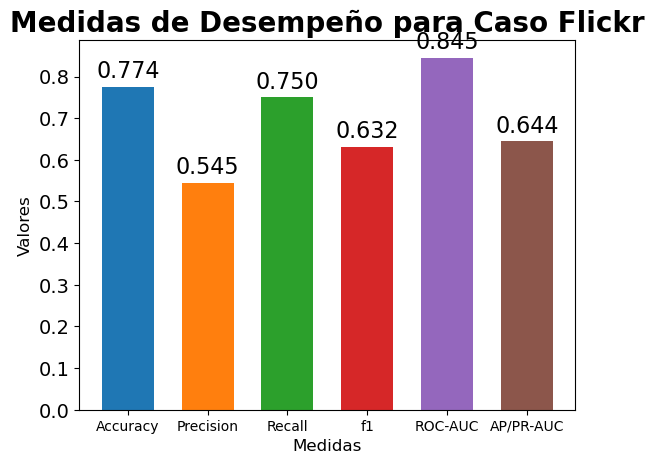

In [81]:
show_bars_metrics(filas_aux[2:8], "Medidas de Desempeño para Caso Flickr")

In [82]:
for nombre, y_pred in y_pred_list_flickr:
    if nombre == "LDA-qt_smote":
        y_pred_aux = y_pred
        break
y_pred_aux

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.])

In [83]:
for nombre, y_pred_proba in y_pred_proba_list_flickr:
    if nombre == "LDA-qt_smote":
        y_pred_proba_aux = y_pred_proba
        break
y_pred_proba_aux

array([0.70952122, 0.35441502, 0.53903868, 0.0768369 , 0.60819962,
       0.07282057, 0.80299791, 0.32754872, 0.52244862, 0.01618429,
       0.95715465, 0.14302583, 0.55899032, 0.03047553, 0.94498362,
       0.41940412, 0.32151662, 0.0485038 , 0.08719692, 0.14131294,
       0.84545834, 0.24432237, 0.41306843, 0.16725418, 0.00195311,
       0.31633821, 0.2081553 , 0.0916091 , 0.27274049, 0.56607793,
       0.09880744, 0.15917751, 0.23674953, 0.24566494, 0.19306747,
       0.38920048, 0.76791755, 0.09389148, 0.30550464, 0.03452255,
       0.95750142, 0.03558709, 0.74819266, 0.34698541, 0.15112223,
       0.48074294, 0.85174049, 0.60642323, 0.278172  , 0.86129773,
       0.310934  , 0.11374363, 0.51588149, 0.01229204, 0.76305598,
       0.44035616, 0.65491562, 0.65737948, 0.31919217, 0.21946312,
       0.60831374, 0.50241147])

[[36 10]
 [ 4 12]]


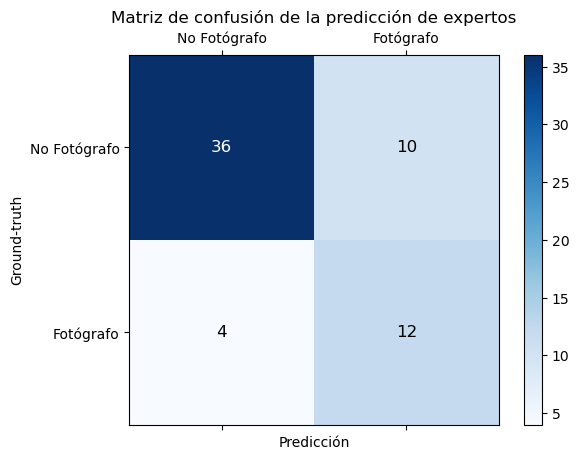

In [84]:
matrix_confusion_pred(test_flickr_y, y_pred_aux)

Best Threshold=0.606423, F-Score=0.688


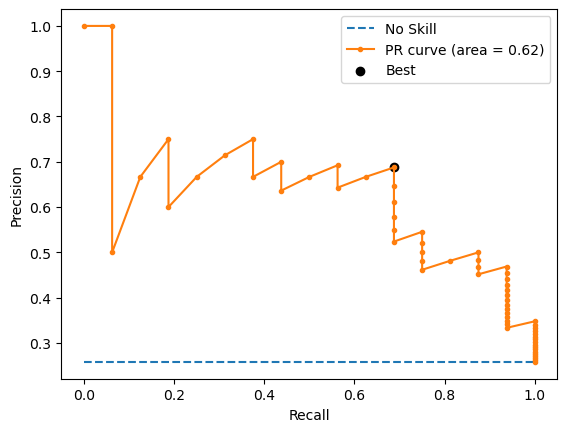

In [85]:
threshold_flickr = pr_auc(test_flickr_y, y_pred_proba_aux)

## Continuación

In [86]:
fila_flickr

modelo            GBM
conjunto          std
accuracy     0.774194
precision       0.625
recall         0.3125
f1           0.416667
AUC-ROC      0.855978
AP/PR-AUC    0.664895
Name: 12, dtype: object

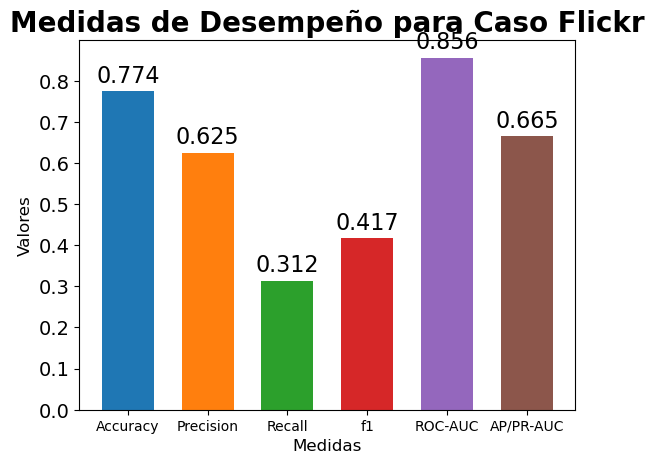

In [87]:
show_bars_metrics(fila_flickr.values[2:8], "Medidas de Desempeño para Caso Flickr")

[[43  3]
 [11  5]]


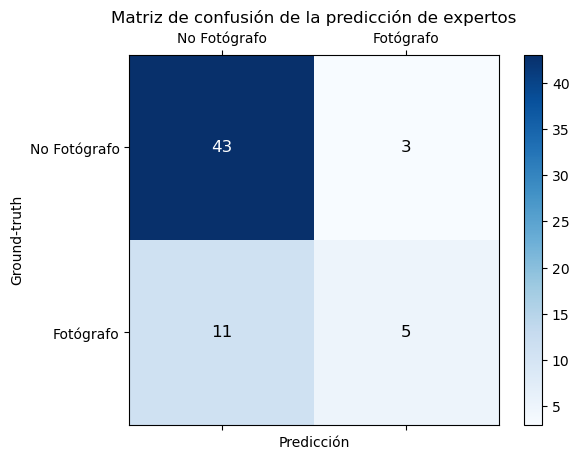

In [88]:
matrix_confusion_pred(test_flickr_y, best_ypred_flickr[1])

In [89]:
y_pred_proba_flickr = best_ypred_proba_flickr[1]

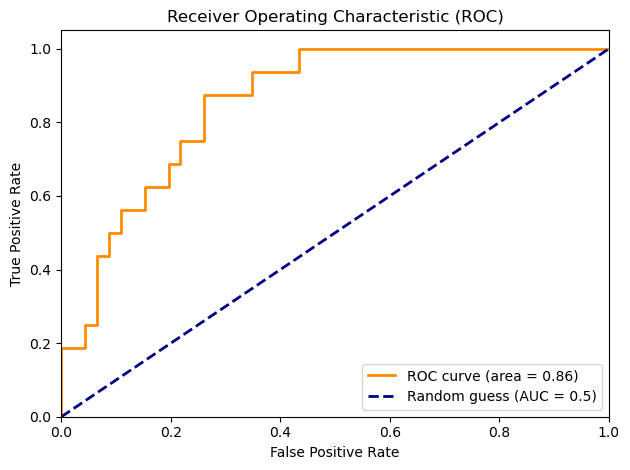

In [90]:
roc_auc(test_flickr_y, y_pred_proba_flickr)

Best Threshold=0.217414, F-Score=0.667


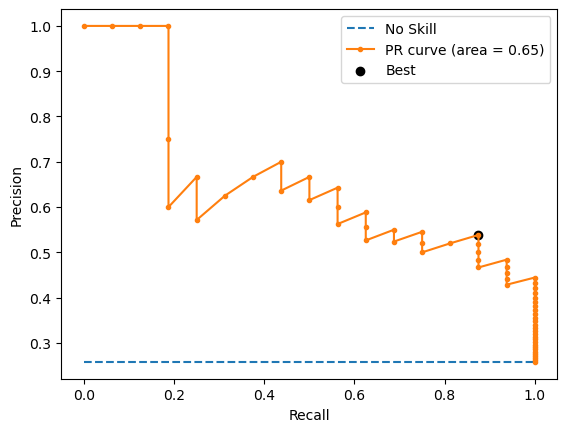

In [91]:
threshold_flickr = pr_auc(test_flickr_y, y_pred_proba_flickr)

In [92]:
# Convertir probabilidades a etiquetas binarias usando el umbral
y_pred_threshold = (y_pred_proba_flickr >= threshold_flickr).astype(int)

# Calcular métricas de rendimiento
f1 = metrics.f1_score(test_flickr_y, y_pred_threshold)
accuracy = metrics.accuracy_score(test_flickr_y, y_pred_threshold)
precision = metrics.precision_score(test_flickr_y, y_pred_threshold)
recall = metrics.recall_score(test_flickr_y, y_pred_threshold)

cm =metrics.confusion_matrix(test_flickr_y, y_pred_threshold)
print(cm)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

[[34 12]
 [ 2 14]]
F1 Score: 0.6666666666666666
Accuracy: 0.7741935483870968
Precision: 0.5384615384615384
Recall: 0.875


# Instagram

In [44]:
df_ig = pd.read_csv(DATASET_IG)
train_ig_x, train_ig_y, test_ig_x, test_ig_y = data_partition(df_ig, 0.3, 'is_photographer')

In [45]:
conjuntos_ig = conjuntos_preprocesamiento(train_ig_x, test_ig_x, train_ig_y, test_ig_y,
                              with_smote=True)
len(conjuntos_ig)

C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(


4

In [46]:
import os

if (not os.path.exists(f"resultados_ig.csv")):
    resultados_ig, best_models_ig, best_hyperparams_ig, matrices_confusion_ig, y_pred_list_ig, y_pred_proba_list_ig = bucle_proceso_general(conjuntos_ig,  grids, scoring = "average_precision")
    resultados_ig.to_csv("resultados_ig.csv", index = False)
    
    fila_ig, nombre_ig = mejor_resultado(resultados_ig, "AP/PR-AUC")
    
    best_model_ig = save_best(best_models_ig, 'mejor_modelo_ig.joblib', nombre_ig)
    best_params_ig = save_best(best_hyperparams_ig, 'mejor_params_ig.joblib', nombre_ig)
    best_matrix_ig = save_best(matrices_confusion_ig, 'mejor_matrix_ig.joblib', nombre_ig)
    best_ypred_ig= save_best(y_pred_list_ig, 'mejor_ypred_ig.joblib', nombre_ig)
    best_ypred_proba_ig = save_best(y_pred_proba_list_ig, 'mejor_ypred_proba_ig.joblib', nombre_ig)
else:
    resultados_ig = pd.read_csv("resultados_ig.csv")
    
    fila_ig, nombre_ig = mejor_resultado(resultados_ig, "AP/PR-AUC")
    
    best_model_ig = joblib.load('mejor_modelo_ig.joblib')
    best_params_ig = joblib.load('mejor_params_ig.joblib')
    best_matrix_ig = joblib.load('mejor_matrix_ig.joblib')
    best_ypred_ig = joblib.load('mejor_ypred_ig.joblib')
    best_ypred_proba_ig= joblib.load('mejor_ypred_proba_ig.joblib')

modelo             LDA
conjunto     std_smote
accuracy      0.618182
precision     0.588235
recall        0.740741
f1            0.655738
AUC-ROC       0.757937
AP/PR-AUC     0.799015
Name: 2, dtype: object
LDA-std_smote


In [47]:
resultados_ig

,modelo,conjunto,accuracy,precision,recall,f1,AUC-ROC,AP/PR-AUC
0,LDA,std,0.618182,0.588235,0.740741,0.655738,0.759259,0.795583
1,LDA,qt,0.672727,0.628571,0.814815,0.709677,0.731481,0.734893
2,LDA,std_smote,0.618182,0.588235,0.740741,0.655738,0.757937,0.799015
3,LDA,qt_smote,0.672727,0.628571,0.814815,0.709677,0.732804,0.743567
4,SVM,std,0.636364,0.606061,0.740741,0.666667,0.736772,0.749681
5,SVM,qt,0.581818,0.566667,0.629630,0.596491,0.666667,0.698697
6,SVM,std_smote,0.636364,0.606061,0.740741,0.666667,0.724868,0.736508
7,SVM,qt_smote,0.545455,0.531250,0.629630,0.576271,0.582011,0.594214
8,RF,std,0.636364,0.606061,0.740741,0.666667,0.708333,0.703350
9,RF,qt,0.654545,0.617647,0.777778,0.688525,0.708333,0.684804


In [48]:
fila_ig

modelo             LDA
conjunto     std_smote
accuracy      0.618182
precision     0.588235
recall        0.740741
f1            0.655738
AUC-ROC       0.757937
AP/PR-AUC     0.799015
Name: 2, dtype: object

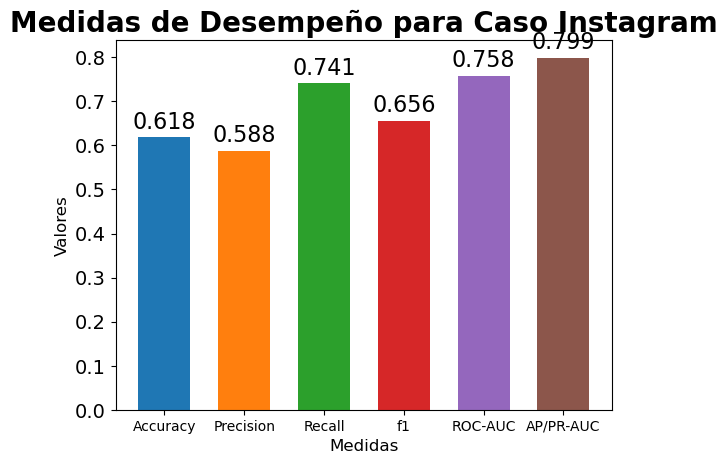

In [98]:
show_bars_metrics(fila_ig.values[2:8], "Medidas de Desempeño para Caso Instagram")

[[14 14]
 [ 7 20]]


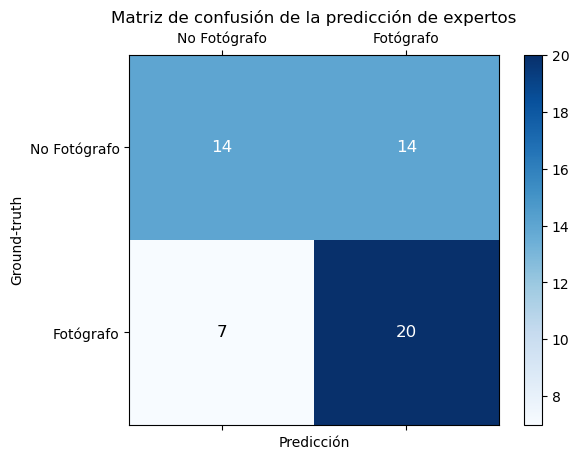

In [99]:
matrix_confusion_pred(test_ig_y, best_ypred_ig[1])

In [100]:
y_pred_proba_ig = best_ypred_proba_ig[1]

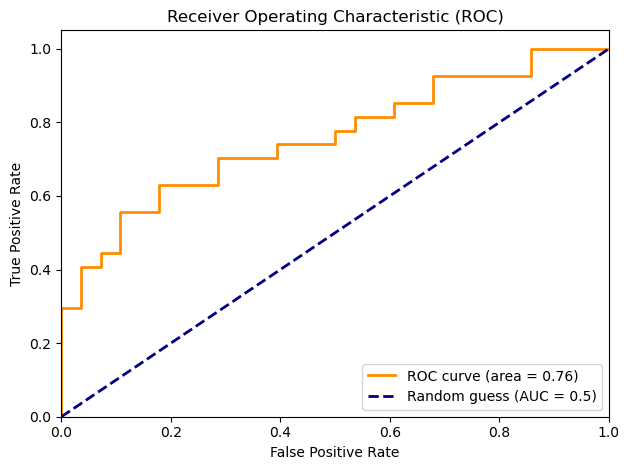

In [101]:
roc_auc(test_ig_y, y_pred_proba_ig)

Best Threshold=0.237382, F-Score=0.704


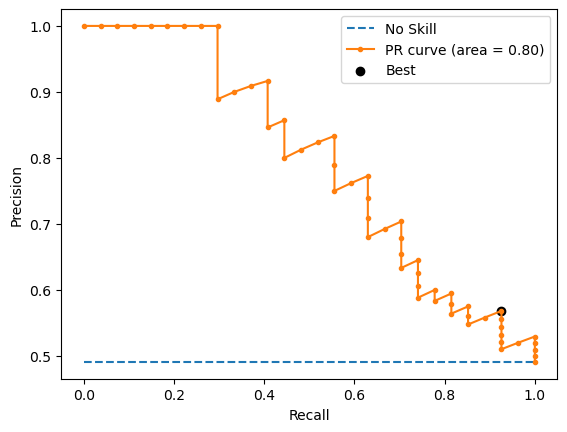

In [102]:
threshold_ig = pr_auc(test_ig_y, y_pred_proba_ig)

In [103]:
# Convertir probabilidades a etiquetas binarias usando el umbral
y_pred_threshold = (y_pred_proba_ig >= threshold_ig).astype(int)

# Calcular métricas de rendimiento
f1 = metrics.f1_score(test_ig_y, y_pred_threshold)
accuracy = metrics.accuracy_score(test_ig_y, y_pred_threshold)
precision = metrics.precision_score(test_ig_y, y_pred_threshold)
recall = metrics.recall_score(test_ig_y, y_pred_threshold)

cm =metrics.confusion_matrix(test_ig_y, y_pred_threshold)
print(cm)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

[[ 9 19]
 [ 2 25]]
F1 Score: 0.704225352112676
Accuracy: 0.6181818181818182
Precision: 0.5681818181818182
Recall: 0.9259259259259259


# Flickr + Instagram

In [34]:
df_igflickr = pd.read_csv(DATASET_FLICK_IG)
train_igflickr_x, train_igflickr_y, test_igflickr_x, test_igflickr_y = data_partition(df_igflickr, 0.3, 'is_photographer')

In [35]:
conjuntos_igflickr = conjuntos_preprocesamiento(train_igflickr_x, test_igflickr_x, train_igflickr_y, test_igflickr_y,
                              with_smote=True)
len(conjuntos_igflickr)

C:\Users\Jesus\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (270). n_quantiles is set to n_samples.
  warnings.warn(


4

In [36]:
import os

if (not os.path.exists(f"resultados_igflickr.csv")):
    resultados_igflickr, best_models_igflickr, best_hyperparams_igflickr, matrices_confusion_igflickr, y_pred_list_igflickr, y_pred_proba_list_igflickr = bucle_proceso_general(conjuntos_igflickr,  grids, scoring = "average_precision")
    resultados_igflickr.to_csv("resultados_igflickr.csv", index = False)
    
    fila_igflickr, nombre_igflickr = mejor_resultado(resultados_igflickr, "AP/PR-AUC")
    
    best_model_igflickr = save_best(best_models_igflickr, 'mejor_modelo_igflickr.joblib', nombre_igflickr)
    best_params_igflickr = save_best(best_hyperparams_igflickr, 'mejor_params_igflickr.joblib', nombre_igflickr)
    best_matrix_igflickr = save_best(matrices_confusion_igflickr, 'mejor_matrix_igflickr.joblib', nombre_igflickr)
    best_ypred_igflickr = save_best(y_pred_list_igflickr, 'mejor_ypred_igflickr.joblib', nombre_igflickr)
    best_ypred_proba_igflickr = save_best(y_pred_proba_list_igflickr, 'mejor_ypred_proba_igflickr.joblib', nombre_igflickr)
else:
    resultados_igflickr = pd.read_csv("resultados_igflickr.csv")
    
    fila_igflickr, nombre_igflickr = mejor_resultado(resultados_igflickr, "AP/PR-AUC")
    
    best_model_igflickr = joblib.load('mejor_modelo_igflickr.joblib')
    best_params_igflickr = joblib.load('mejor_params_igflickr.joblib')
    best_matrix_igflickr = joblib.load('mejor_matrix_igflickr.joblib')
    best_ypred_igflickr = joblib.load('mejor_ypred_igflickr.joblib')
    best_ypred_proba_igflickr = joblib.load('mejor_ypred_proba_igflickr.joblib')
    

modelo             LDA
conjunto     std_smote
accuracy      0.769231
precision     0.637931
recall        0.860465
f1            0.732673
AUC-ROC       0.846637
AP/PR-AUC     0.762385
Name: 2, dtype: object
LDA-std_smote


In [37]:
resultados_igflickr

,modelo,conjunto,accuracy,precision,recall,f1,AUC-ROC,AP/PR-AUC
0,LDA,std,0.735043,0.650000,0.604651,0.626506,0.841609,0.752966
1,LDA,qt,0.726496,0.657143,0.534884,0.589744,0.830924,0.754805
2,LDA,std_smote,0.769231,0.637931,0.860465,0.732673,0.846637,0.762385
3,LDA,qt_smote,0.692308,0.557377,0.790698,0.653846,0.816782,0.734757
4,SVM,std,0.769231,0.660000,0.767442,0.709677,0.835009,0.726456
5,SVM,qt,0.726496,0.587302,0.860465,0.698113,0.830924,0.760854
6,SVM,std_smote,0.606838,0.384615,0.116279,0.178571,0.660591,0.463893
7,SVM,qt_smote,0.606838,0.333333,0.069767,0.115385,0.583281,0.431156
8,RF,std,0.726496,0.666667,0.511628,0.578947,0.815211,0.687931
9,RF,qt,0.700855,0.617647,0.488372,0.545455,0.805783,0.658531


In [38]:
fila_igflickr

modelo             LDA
conjunto     std_smote
accuracy      0.769231
precision     0.637931
recall        0.860465
f1            0.732673
AUC-ROC       0.846637
AP/PR-AUC     0.762385
Name: 2, dtype: object

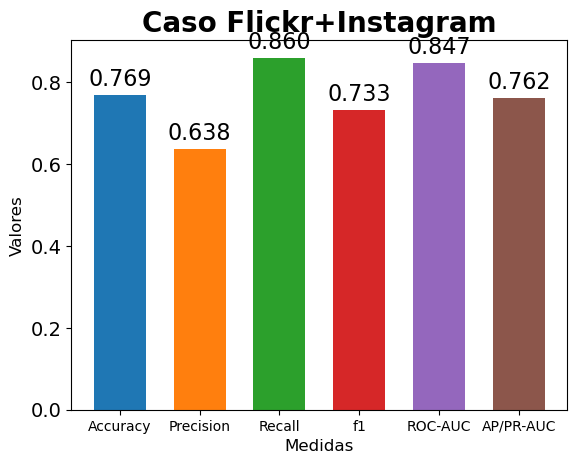

In [39]:
show_bars_metrics(fila_igflickr.values[2:8], "Caso Flickr+Instagram")

[[53 21]
 [ 6 37]]


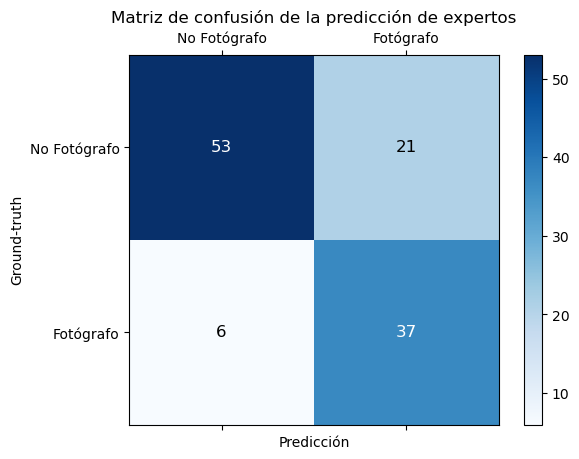

In [110]:
matrix_confusion_pred(test_igflickr_y, best_ypred_igflickr[1])

In [111]:
y_pred_proba_igflickr = best_ypred_proba_igflickr[1]

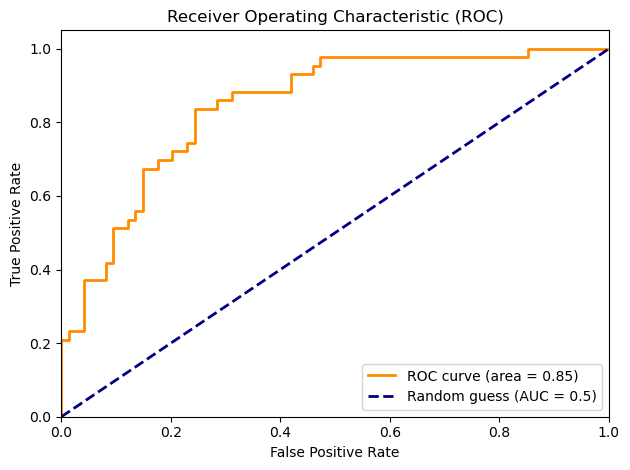

In [112]:
roc_auc(test_igflickr_y, y_pred_proba_igflickr)

Best Threshold=0.542783, F-Score=0.742


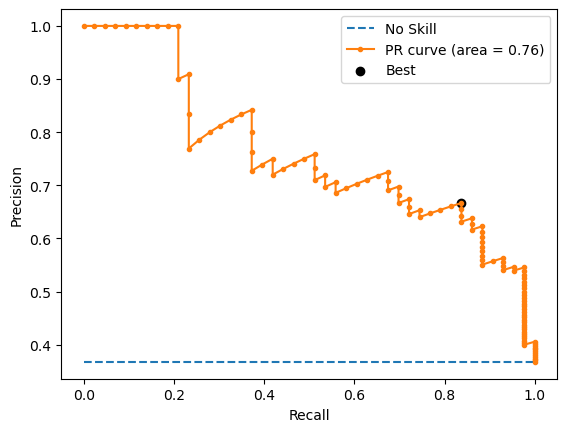

In [113]:
threshold_igflickr = pr_auc(test_igflickr_y, y_pred_proba_igflickr)

In [114]:
# Convertir probabilidades a etiquetas binarias usando el umbral
y_pred_threshold = (y_pred_proba_igflickr >= threshold_igflickr).astype(int)

# Calcular métricas de rendimiento
f1 = metrics.f1_score(test_igflickr_y, y_pred_threshold)
accuracy = metrics.accuracy_score(test_igflickr_y, y_pred_threshold)
precision = metrics.precision_score(test_igflickr_y, y_pred_threshold)
recall = metrics.recall_score(test_igflickr_y, y_pred_threshold)

cm =metrics.confusion_matrix(test_igflickr_y, y_pred_threshold)
print(cm)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

[[56 18]
 [ 7 36]]
F1 Score: 0.7422680412371134
Accuracy: 0.7863247863247863
Precision: 0.6666666666666666
Recall: 0.8372093023255814


# Modelo Instagram con Datos Flickr

In [49]:
fila_ig

modelo             LDA
conjunto     std_smote
accuracy      0.618182
precision     0.588235
recall        0.740741
f1            0.655738
AUC-ROC       0.757937
AP/PR-AUC     0.799015
Name: 2, dtype: object

In [50]:
nombre_ig

'LDA-std_smote'

In [51]:
flickr_x = df_flickr.loc[:, df_flickr.columns != 'is_photographer']
flickr_y = df_flickr.loc[:, 'is_photographer']

scaler = StandardScaler()
scaler.fit(flickr_x)
flickrScaled_x = pd.DataFrame(scaler.transform(flickr_x), columns=flickr_x.columns, index=flickr_x.index)

In [52]:
y_pred1 = best_model_ig[1].predict(flickrScaled_x)
cm1 = confusion_matrix(flickr_y, y_pred1)
cm1

array([[95, 58],
       [ 9, 43]], dtype=int64)

[[95 58]
 [ 9 43]]


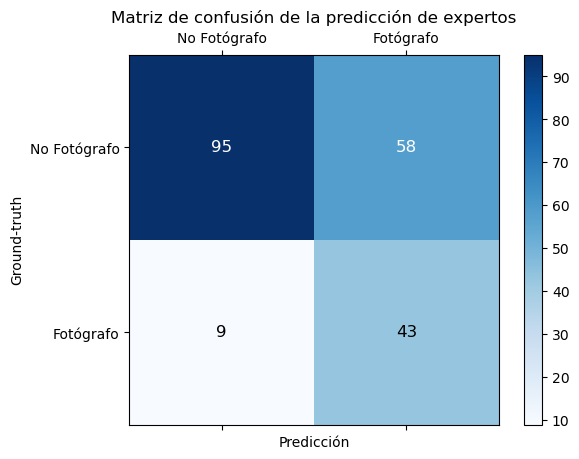

In [149]:
matrix_confusion_pred(flickr_y, y_pred1)

In [53]:
y_pred_proba1 = best_model_ig[1].predict_proba(flickr_x)[:,-1]
roc_auc1 = metrics.roc_auc_score(flickr_y, y_pred_proba1)
print("ROC-AUC", round(roc_auc1, 4))
            
average_precision1 = metrics.average_precision_score(flickr_y, y_pred_proba1)
print("AP/PR-AUC: ",round(average_precision1,4))

# Calcular las métricas de rendimiento
accuracy = metrics.accuracy_score(flickr_y, y_pred1)
precision = metrics.precision_score(flickr_y, y_pred1)
recall = metrics.recall_score(flickr_y, y_pred1)
f1 = metrics.f1_score(flickr_y, y_pred1)

ROC-AUC 0.6942
AP/PR-AUC:  0.453


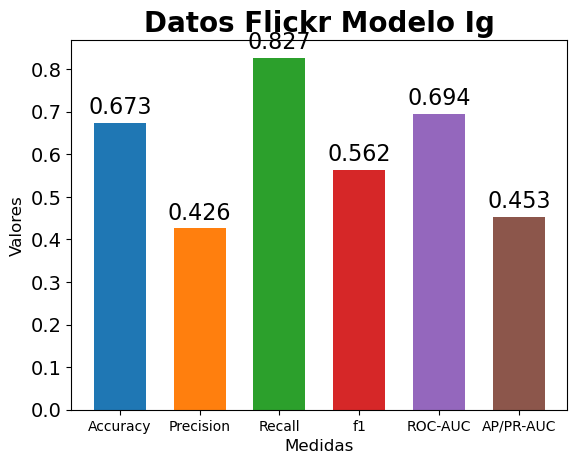

In [54]:
show_bars_metrics([accuracy, precision, recall, f1, roc_auc1, average_precision1], "Datos Flickr Modelo Ig")

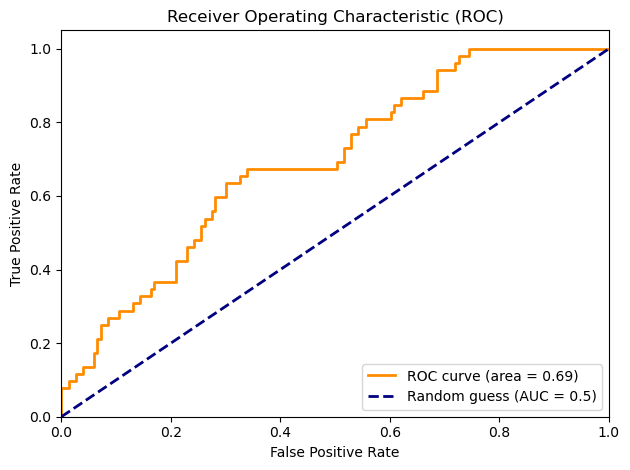

In [121]:
roc_auc(flickr_y, y_pred_proba1)

Best Threshold=0.778828, F-Score=0.504


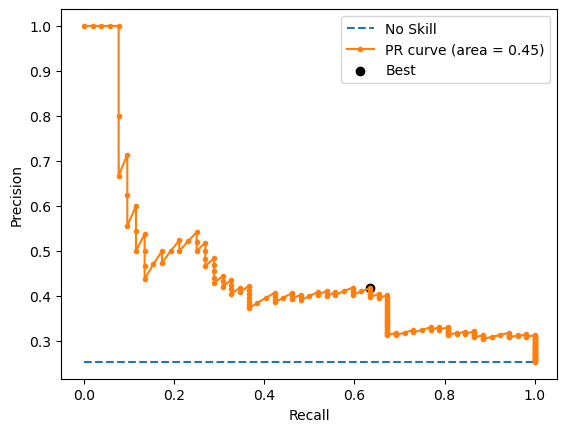

In [122]:
threshold1 = pr_auc(flickr_y, y_pred_proba1)

In [123]:
# Para obtener los datos de Flickr preprocesados según el modelo de IG
tupla_1 = find_preproc(nombre_ig.split('-')[1], conjuntos_flickr)

std
qt
std_smote


In [124]:
y_pred1 = best_model_ig[1].predict(tupla_1[3])
cm1 = confusion_matrix(tupla_1[4], y_pred1)
cm1

array([[32, 14],
       [ 3, 13]], dtype=int64)

In [125]:
best_model_ig[1]

LinearDiscriminantAnalysis(store_covariance=True, tol=0.01)

In [126]:
y_pred_proba1 = best_model_ig[1].predict_proba(tupla_1[3])[:,-1]
roc_auc1 = metrics.roc_auc_score(tupla_1[4], y_pred_proba1)
print("ROC-AUC", round(roc_auc1, 4))
            
average_precision1 = metrics.average_precision_score(tupla_1[4], y_pred_proba1)
print("AP/PR-AUC: ",round(average_precision1,4))

# Calcular las métricas de rendimiento
accuracy = metrics.accuracy_score(tupla_1[4], y_pred1)
precision = metrics.precision_score(tupla_1[4], y_pred1)
recall = metrics.recall_score(tupla_1[4], y_pred1)
f1 = metrics.f1_score(tupla_1[4], y_pred1)

ROC-AUC 0.7731
AP/PR-AUC:  0.5357


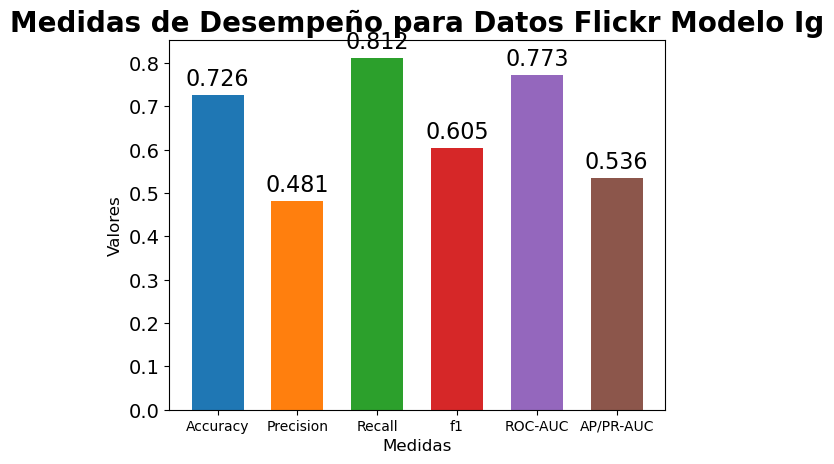

In [127]:
show_bars_metrics([accuracy, precision, recall, f1, roc_auc1, average_precision1], "Datos Flickr Modelo Ig")

# Modelo Flickr con Datos Instagram

In [128]:
fila_flickr

modelo            GBM
conjunto          std
accuracy     0.774194
precision       0.625
recall         0.3125
f1           0.416667
AUC-ROC      0.855978
AP/PR-AUC    0.664895
Name: 12, dtype: object

In [129]:
nombre_flickr

'GBM-std'

In [130]:
# Para obtener los datos de IG preprocesados según el modelo de Flickr
tupla_2 = find_preproc(nombre_flickr.split('-')[1], conjuntos_ig)

std


In [132]:
for nombre, model in best_models_flickr:
    if nombre == "LDA-qt_smote":
        model_aux = model
        break
model_aux

LinearDiscriminantAnalysis(store_covariance=True, tol=0.01)

In [133]:
ig_x = df_ig.loc[:, df_flickr.columns != 'is_photographer']
ig_y = df_ig.loc[:, 'is_photographer']

scaler = StandardScaler()
scaler.fit(ig_x)
igScaled_x = pd.DataFrame(scaler.transform(ig_x), columns=ig_x.columns, index=ig_x.index)

In [150]:
y_pred2 = model_aux.predict(igScaled_x)
cm1 = confusion_matrix(ig_y, y_pred2)
cm1

array([[62, 31],
       [42, 47]], dtype=int64)

[[62 31]
 [42 47]]


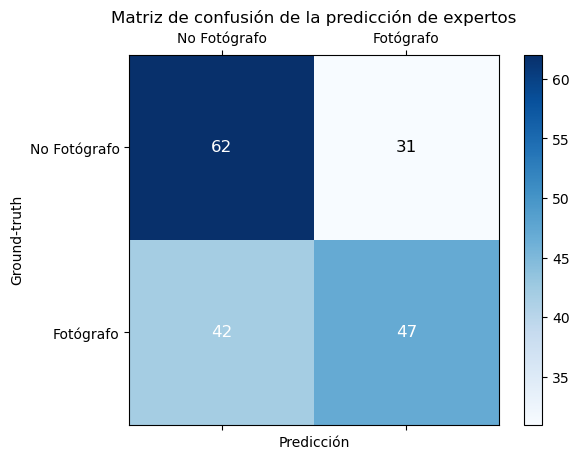

In [151]:
matrix_confusion_pred(ig_y, y_pred2)

In [143]:
roc_auc

0.845108695652174

In [135]:
y_pred_proba2 = model_aux.predict_proba(ig_x)[:,-1]
roc_auc2 = metrics.roc_auc_score(ig_y, y_pred_proba2)
print("ROC-AUC", round(roc_auc2, 4))
            
average_precision2 = metrics.average_precision_score(ig_y, y_pred_proba2)
print("AP/PR-AUC: ",round(average_precision2,4))

# Calcular las métricas de rendimiento
accuracy = metrics.accuracy_score(ig_y, y_pred2)
precision = metrics.precision_score(ig_y, y_pred2)
recall = metrics.recall_score(ig_y, y_pred2)
f1 = metrics.f1_score(ig_y, y_pred2)

ROC-AUC 0.628
AP/PR-AUC:  0.5506


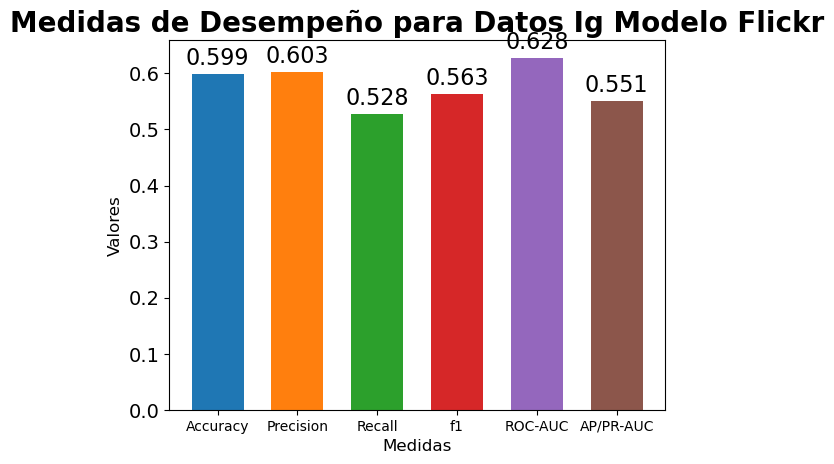

In [136]:
show_bars_metrics([accuracy, precision, recall, f1, roc_auc2, average_precision2], "Datos Ig Modelo Flickr")

In [144]:
del(roc_auc)

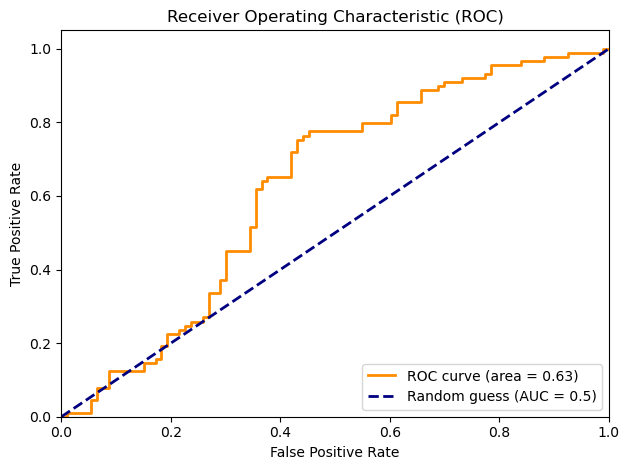

In [147]:
roc_auc(ig_y, y_pred_proba2)

Best Threshold=0.677128, F-Score=nan


C:\Users\Jesus\AppData\Local\Temp\ipykernel_15460\1706504695.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


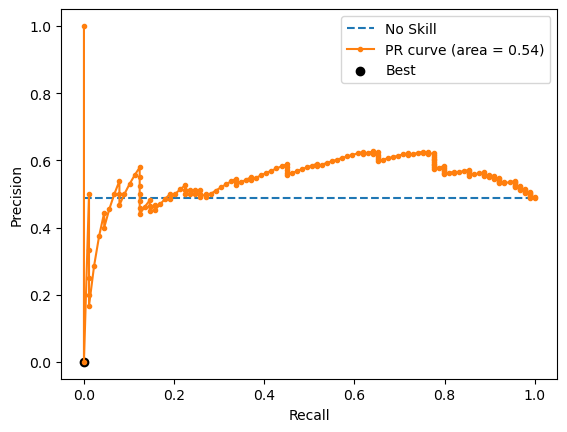

In [142]:
threshold2 = pr_auc(ig_y, y_pred_proba2)

In [ ]:
best_model_flickr[1]

In [ ]:
y_pred2 = best_model_ig[1].predict(tupla_2[3])
cm2 = confusion_matrix(tupla_2[4], y_pred2)
cm2

In [ ]:
y_pred_proba2 = best_model_flickr[1].predict_proba(tupla_2[3])[:,-1]
roc_auc2 = metrics.roc_auc_score(tupla_2[4], y_pred_proba2)
print("ROC-AUC", round(roc_auc2, 4))
            
average_precision2 = metrics.average_precision_score(tupla_2[4], y_pred_proba2)
print("AP/PR-AUC: ",round(average_precision2,4))

# Calcular las métricas de rendimiento
accuracy = metrics.accuracy_score(tupla_2[4], y_pred2)
precision = metrics.precision_score(tupla_2[4], y_pred2)
recall = metrics.recall_score(tupla_2[4], y_pred2)
f1 = metrics.f1_score(tupla_2[4], y_pred2)

In [ ]:
show_bars_metrics([accuracy, precision, recall, f1, roc_auc2, average_precision2], "Medidas de Desempeño para Datos Ig Modelo Flickr")